<h1> <center><font color='green' > <b>AGN Classifier for AGNDB</b></font> </center></h1>

# Model Building
by Sicong Huang <br> \
<font color='blue'>Python Version: 3.6.5 <br>
AGNDB Version: 1.1.0

# THE QUESTION: <br><font color='green'>How to use ML methods to classify agn and non-agns?</font>

# Goal of the Model Building
<font color='green'> Train models to find and remove stars and galaxies in AGNDB.

# Analytic Approach
<font color='green'>__Machine learning & deep learning__:
- Logistic Regression
- Kernal SVM
- Random Forest
- KNN
- Convolutional Neural Network

# IMPORT LIBRARIES

In [1]:
# System
import os
import glob
from tqdm import tqdm
from IPython.display import Markdown, display, Audio

# Web Scraping

# Data Analysis
import pandas as pd
import numpy as np

# Machine Learning
from scipy import stats
import sklearn
import joblib
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as ms
import sklearn.ensemble as ske
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Neural Network
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import Callback

import keras.backend as K

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

In [2]:
# import sys
# !conda install --yes --prefix {sys.prefix} tensorflow

# Functions

In [2]:
def sound_effect(fail=0):
    """
    Play a sound when job is finished
    """
    if fail == 0:
        sound_file = '/data/home/sicong/sounds/jobs-done_1.mp3'
        display(Audio(sound_file, autoplay=True))
    else:
        sound_file = '/data/home/sicong/sounds/oh-shit-im-sorry_0001.mp3'
        display(Audio(sound_file, autoplay=True))

In [3]:
def printmd(string):
    """
    print in markdown style
    """
    display(Markdown(string))

In [4]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1.5) 
    ax = sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    ax.set(xlabel='Predicted Values', ylabel='Actual Value')
    plt.show()
    

# Data Understanding:

## Known Issues:

<ul>
  <font color='green'><li>Only a small fraction is labeled data</li></font>
    <ul><li>Get more data</li></ul>    
  <font color='green'><li>High fraction of missing values</li></font>  
    <ul><li>Select 20% of the whole dataset with least amount of Nan</li></ul>
  <font color='green'><li>Highly imbalanced data</li></font>
    <ul><li>Use appropriate evaluation metrics</li></ul>
  <font color='green'><li>Validation vs cross-validation</li></font>
</ul>

## Read train/dev/test sets

In [5]:
df_train = pd.read_pickle('agncl_train.pkl')
df_dev = pd.read_pickle('agncl_dev.pkl')
df_test = pd.read_pickle('agncl_test.pkl')

In [6]:
df_train.head(2)

,RA,DEC,AGN,best_z,i_mag,r_mag,z_mag,u_mag,g_mag,e_i_mag,...,e_rf10,rf10,e_rf12,rf12,W1_mag,W2_mag,e_W1_mag,W4_mag,W3_mag,e_W2_mag
220605,34.29,-4.92,1.00,1.46,22.71,22.90,22.45,23.82,23.18,0.01,...,12.87,0.01,"746,494.45",0.02,18.54,18.07,0.00,15.26,16.80,0.00
387256,197.74,24.76,0.00,1.94,19.79,19.99,19.68,20.26,20.11,0.02,...,5.56,94.28,"230,990.92",0.14,18.54,18.07,0.00,15.26,16.80,0.00


In [7]:
df_dev.head(2)

,RA,DEC,AGN,best_z,i_mag,r_mag,z_mag,u_mag,g_mag,e_i_mag,...,e_rf10,rf10,e_rf12,rf12,W1_mag,W2_mag,e_W1_mag,W4_mag,W3_mag,e_W2_mag
19276,16.93,1.00,1.00,0.90,20.68,20.69,20.40,20.92,20.78,0.00,...,6.52,122.01,"234,124.72",0.15,18.74,18.41,2.76,15.48,17.10,3.42
333469,163.61,7.23,0.00,0.98,19.79,19.76,19.76,19.98,19.91,0.02,...,7.31,124.05,"190,897.13",0.20,18.30,17.76,0.00,15.23,16.55,0.00


In [8]:
print(f'Training set size: {df_train.shape}')
print(f'Dev set size: {df_dev.shape}')
print(f'Testing set size: {df_test.shape}')

Training set size: (15516, 29)
Dev set size: (3880, 29)
Testing set size: (11485, 29)


## Convert train/dev/test dataframe to numpy array

In [9]:
#(x_train, x_dev, x_test, y_train, y_dev, y_test) = 
features = list(set(df_train.columns) - {'best_class','AGN','RA','DEC'})
x_train = np.array(df_train[features])
y_train = np.array(df_train['AGN'])

x_dev = np.array(df_dev[features])
y_dev = np.array(df_dev['AGN'])

x_test = np.array(df_test[features])

In [11]:
print ("Number of training examples: m_train = " + str(x_train.shape[0]))
print ("Number of validataion examples: m_dev = " + str(x_dev.shape[0]))
print ("Number of testing examples: m_test = " + str(x_test.shape[0]))

print ("train_set_x shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("dev_set_x shape: " + str(x_dev.shape))
print ("dev_set_y shape: " + str(y_dev.shape))
print ("test_set_x shape: " + str(x_test.shape))

Number of training examples: m_train = 15516
Number of validataion examples: m_dev = 3880
Number of testing examples: m_test = 11485
train_set_x shape: (15516, 26)
train_set_y shape: (15516,)
dev_set_x shape: (3880, 26)
dev_set_y shape: (3880,)
test_set_x shape: (11485, 26)


In [12]:
print(*features,sep='\n')

r_mag
e_r_mag
g_extinction
e_z_mag
e_i_mag
e_u_mag
i_mag
W1_mag
e_W2_mag
u_extinction
rf10
e_W1_mag
i_extinction
u_mag
z_extinction
e_rf12
W2_mag
e_rf10
W4_mag
best_z
g_mag
r_extinction
e_g_mag
rf12
W3_mag
z_mag


In [13]:
len(features)

26

## Normalize

In [14]:
x_train = (x_train - x_train.mean(axis=0)) / (x_train.std(axis=0))
x_dev = (x_dev - x_dev.mean(axis=0)) / (x_dev.std(axis=0))
x_test = (x_test - x_test.mean(axis=0)) / (x_test.std(axis=0))

In [15]:
# check for nan in sets
np.sum(np.isnan(x_dev))

0

## Notice that the data is NOT imbalanced anymore.
<font color='green'> 
</font>



In [16]:
printmd("<font color='red'>Training set:")
print(f"AGN: {100*len(df_train[df_train['AGN']==1])/len(df_train):.2f}%, \
      non-AGN: {100*len(df_train[df_train['AGN']==0])/len(df_train):.2f}%")

printmd("<font color='red'>Dev set:")
print(f"AGN: {100*len(df_dev[df_dev['AGN']==1])/len(df_dev):.2f}%, \
      non-AGN: {100*len(df_dev[df_dev['AGN']==0])/len(df_dev):.2f}%")

<font color='red'>Training set:

AGN: 50.28%,       non-AGN: 49.72%


<font color='red'>Dev set:

AGN: 48.87%,       non-AGN: 51.13%


# Data Modeling

## Logistic Regression

<font color='green'>Load model from file

In [32]:
joblib_file = "LR_Model.pkl"  
lr = joblib.load(joblib_file)

/home/jack/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [58]:
%store -r yhat_train_lr
%store -r yhat_dev_lr
%store -r yhat_train_prob_lr
%store -r yhat_dev_prob_lr

<font color='green'> Simple Logistic Regression

In [17]:
%%time
# Ignore imbalance
lr = LogisticRegression(solver='newton-cg')
lr.fit(x_train, y_train)

CPU times: user 24.2 s, sys: 59.9 s, total: 1min 24s
Wall time: 3.19 s


LogisticRegression(solver='newton-cg')

In [18]:
#Predicting on the test data
yhat_train_lr = lr.predict(x_train)
yhat_train_prob_lr = lr.predict_proba(x_train)

yhat_dev_lr = lr.predict(x_dev)
yhat_dev_prob_lr = lr.predict_proba(x_dev)

In [21]:
yhat_train_prob_lr.shape

(15516, 2)

The f1 score for the training data: 0.7507836990595611
The f1 score for the dev data: 0.7474321833026073


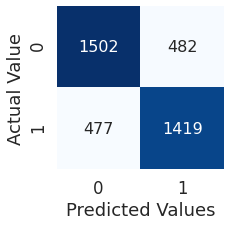

In [20]:
#Calculating and printing the f1 score 
f1_test = f1_score(y_train, yhat_train_lr)
print('The f1 score for the training data:', f1_test)

f1_test = f1_score(y_dev, yhat_dev_lr)
print('The f1 score for the dev data:', f1_test)

# Plot Confusion Matrix
conf_matrix(y_dev, yhat_dev_lr)

<font color='green'> Logistic Regression (Manual class weights)

<font color='red'> __Conclusion__:</font>
<font color='green'>
- The performance on the dev set is not good. Check later for variance or bias problem.

In [25]:
%%time
# !Caution: long run time required
# Find the best hyperparameter c
grid = GridSearchCV(lr, {'C': np.logspace(-5, 5, 100)}, n_jobs=4)
grid.fit(x_train, y_train)
print(grid.best_params_)
scores = ms.cross_val_score(grid.best_estimator_, x_dev, y_dev, scoring='f1')
print("Dev set f1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

{'C': 0.7054802310718645}
Dev set f1 score: 0.75 (+/- 0.04)
CPU times: user 1min 21s, sys: 3min 2s, total: 4min 23s
Wall time: 1min 4s


<font color='green'> Save model to file

In [26]:
joblib_file = "LR_Model.pkl"  
joblib.dump(lr, joblib_file)

['LR_Model.pkl']

In [27]:
%store yhat_train_lr
%store yhat_dev_lr
%store yhat_train_prob_lr
%store yhat_dev_prob_lr

Stored 'yhat_train_lr' (ndarray)
Stored 'yhat_dev_lr' (ndarray)
Stored 'yhat_train_prob_lr' (ndarray)
Stored 'yhat_dev_prob_lr' (ndarray)


## Decision Tree

<font color='green'> Load model from file

In [15]:
joblib_file = "Tree_Model.pkl"  
Tree = joblib.load(joblib_file)

In [70]:
%store -r yhat_train_Tree
%store -r yhat_dev_Tree
%store -r yhat_train_prob_Tree
%store -r yhat_dev_prob_Tree

<font color='green'> class_weight='none'

In [28]:
# d is the depth of the forest
depths, f1_trains, f1_devs = [], [], []
for d in range(1,100):
    Tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = d).fit(x_train, y_train)
    yhat_dev = Tree.predict(x_dev)
    yhat_train = Tree.predict(x_train)
    depths.append(d)
    f1_train=f1_score(y_train, yhat_train)
    f1_trains.append(f1_train)
    f1_dev=f1_score(y_dev, yhat_dev)
    f1_devs.append(f1_dev)
    print(f"For depth = {d}  the training set f1 score is {f1_train}")
    print(f"For depth = {d}  the dev set f1 score is {f1_dev}")    

For depth = 1  the training set f1 score is 0.6696866181494133
For depth = 1  the dev set f1 score is 0.6762075134168157
For depth = 2  the training set f1 score is 0.6647823629169022
For depth = 2  the dev set f1 score is 0.6748944462487821
For depth = 3  the training set f1 score is 0.7522149185481566
For depth = 3  the dev set f1 score is 0.7468060394889662
For depth = 4  the training set f1 score is 0.7829832350407528
For depth = 4  the dev set f1 score is 0.7780763030628695
For depth = 5  the training set f1 score is 0.7951600105792118
For depth = 5  the dev set f1 score is 0.7903780068728523
For depth = 6  the training set f1 score is 0.8024987986544931
For depth = 6  the dev set f1 score is 0.7588168373151308
For depth = 7  the training set f1 score is 0.8189556940813728
For depth = 7  the dev set f1 score is 0.7009630005068423
For depth = 8  the training set f1 score is 0.8288651481556139
For depth = 8  the dev set f1 score is 0.7017633529261437
For depth = 9  the training set 

For depth = 71  the training set f1 score is 1.0
For depth = 71  the dev set f1 score is 0.6524243879020643
For depth = 72  the training set f1 score is 1.0
For depth = 72  the dev set f1 score is 0.6693320790216369
For depth = 73  the training set f1 score is 1.0
For depth = 73  the dev set f1 score is 0.6612362242453281
For depth = 74  the training set f1 score is 1.0
For depth = 74  the dev set f1 score is 0.6565802113352546
For depth = 75  the training set f1 score is 1.0
For depth = 75  the dev set f1 score is 0.6751740139211138
For depth = 76  the training set f1 score is 1.0
For depth = 76  the dev set f1 score is 0.6533749699735768
For depth = 77  the training set f1 score is 1.0
For depth = 77  the dev set f1 score is 0.6666666666666666
For depth = 78  the training set f1 score is 1.0
For depth = 78  the dev set f1 score is 0.6728884741017266
For depth = 79  the training set f1 score is 1.0
For depth = 79  the dev set f1 score is 0.6554298097760655
For depth = 80  the training

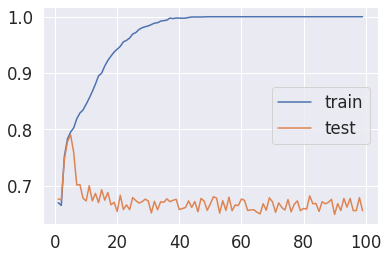

In [30]:
plt.plot(depths, f1_trains, label='train')
plt.plot(depths, f1_devs, label='test')
plt.legend()
plt.show()

In [36]:
Tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5).fit(x_train, y_train)

In [37]:
yhat_dev_Tree = Tree.predict(x_dev)
yhat_train_Tree = Tree.predict(x_train)
yhat_dev_prob_Tree = Tree.predict_proba(x_dev)
yhat_train_prob_Tree = Tree.predict_proba(x_train)

For depth = 5  the training set f1 score is 0.7951600105792118
For depth = 5  the dev set f1 score is 0.7903780068728523


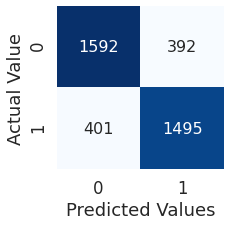

In [39]:
d=5
print(f"For depth = {d}  the training set f1 score is {f1_score(y_train, yhat_train_Tree)}")
print(f"For depth = {d}  the dev set f1 score is {f1_score(y_dev, yhat_dev_Tree)}") 

# Plot Confusion Matrix
conf_matrix(y_dev, yhat_dev_Tree)

<font color='red'> __Conclusion__:</font>
<font color='green'>

- The best performance overall is d=4 or 5  with f1_train and f1_dev ~ 80%, indicating high bias. 

<font color='green'> Save model to file

In [40]:
joblib_file = "Tree_Model.pkl"  
joblib.dump(Tree, joblib_file)

['Tree_Model.pkl']

In [41]:
%store yhat_train_Tree
%store yhat_dev_Tree
%store yhat_train_prob_Tree
%store yhat_dev_prob_Tree

Stored 'yhat_train_Tree' (ndarray)
Stored 'yhat_dev_Tree' (ndarray)
Stored 'yhat_train_prob_Tree' (ndarray)
Stored 'yhat_dev_prob_Tree' (ndarray)


## K Nearest Neighbors

<font color='green'>Load model from file

In [64]:
joblib_file = "KNN_Model.pkl"  
knn = joblib.load(joblib_file)

In [71]:
%store -r yhat_train_knn
%store -r yhat_dev_knn

In [72]:
%store -r yhat_train_prob_knn
%store -r yhat_dev_prob_knn

In [65]:
# find the best K
Ks = 15
mean_acc_train = np.zeros((Ks-1))
std_acc_train = np.zeros((Ks-1))
mean_acc_dev = np.zeros((Ks-1))
std_acc_dev = np.zeros((Ks-1))

for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    
    yhat_train=neigh.predict(x_train)
    yhat_dev=neigh.predict(x_dev)
    
    mean_acc_train[n-1] = f1_score(y_train, yhat_train)
    std_acc_train[n-1]=np.std(yhat_train==y_train)/np.sqrt(yhat_train.shape[0])
    
    mean_acc_dev[n-1] = f1_score(y_dev, yhat_dev)
    std_acc_dev[n-1]=np.std(yhat_dev==y_dev)/np.sqrt(yhat_dev.shape[0])

print('Training set:')
print(mean_acc_train)
print( "The best f1 score was with", mean_acc_train.max(), "with k=", mean_acc_train.argmax()+1) 

print('Dev set:')
print(mean_acc_dev)
print( "The best f1 score was with", mean_acc_dev.max(), "with k=", mean_acc_dev.argmax()+1) 

Training set:
[1.         0.86060606 0.87746673 0.83835306 0.85127384 0.8315362
 0.83971003 0.82434977 0.83046152 0.82162539 0.82562084 0.81629815
 0.82150625 0.81401168]
The best f1 score was with 1.0 with k= 1
Dev set:
[0.75026123 0.73709484 0.7801229  0.77841561 0.78817467 0.78413598
 0.79181446 0.79367767 0.7994513  0.80033793 0.80055021 0.79277244
 0.80044101 0.79708111]
The best f1 score was with 0.800550206327373 with k= 11


In [66]:
%%time
# build the model with the best K=7
k = 11
knn = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 129 ms


In [67]:
%%time
yhat_train_knn=knn.predict(x_train)

CPU times: user 5.87 s, sys: 0 ns, total: 5.87 s
Wall time: 5.88 s


In [68]:
%%time
yhat_dev_knn=knn.predict(x_dev)

CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.71 s


In [69]:
%%time
yhat_train_prob_knn=knn.predict_proba(x_train)

CPU times: user 5.31 s, sys: 0 ns, total: 5.31 s
Wall time: 5.32 s


In [70]:
%%time
yhat_dev_prob_knn=knn.predict_proba(x_dev)

CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.57 s


The training set f1 score is 0.8256208440765368
The dev set f1 score is 0.800550206327373


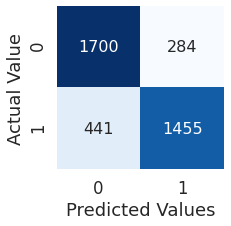

In [71]:
print(f"The training set f1 score is {f1_score(y_train, yhat_train_knn)}")
print(f"The dev set f1 score is {f1_score(y_dev, yhat_dev_knn)}") 

# Plot Confusion Matrix
conf_matrix(y_dev, yhat_dev_knn)

<font color='red'> __Conclusion__:</font>
<font color='green'>
- Similar performance as Decision Tree.
- Takes much longer to run.

<font color='green'> Save model to file

In [72]:
joblib_file = "KNN_Model.pkl"  
joblib.dump(knn, joblib_file)

['KNN_Model.pkl']

In [73]:
%store yhat_train_knn
%store yhat_dev_knn

Stored 'yhat_train_knn' (ndarray)
Stored 'yhat_dev_knn' (ndarray)


In [74]:
%store yhat_train_prob_knn
%store yhat_dev_prob_knn

Stored 'yhat_train_prob_knn' (ndarray)
Stored 'yhat_dev_prob_knn' (ndarray)


## Neural Network
Based on https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.3951C/abstract 

The structure of the network from the paper is as follows:
<img src="./images/NN_structure_paper.jpg">
- Input size = (44x2x1)
- Kernel size = (1x2)
- Kernel # for CNN = 16, 32, 32

<font color='red'>
Input => CNN => ReLU => CNN => ReLU => CNN => ReLU => FC => ReLU => FC => ReLU => Sigmoid => Output</font>

The work flow in this paper is as follows:
<img src="./images/NN_workflow_paper.jpg" >

The training epochs come to the end when a specific condition
is satisfied. This termination condition generally could be written
as:
<img src="./images/condition_paper.jpg" >

The loss function is define as a modified cross-entropy loss function for
up-weighting the lesser class in the training samples:
<img src="./images/loss_paper.jpg" >
Notice that the lesser class in the paper is AGN, while in our database is non-AGN.
We will try the normal loss function first, then use this modified function later.

For retais in this paper:
- Adam
- L2 and dropout
- Batch Normalization
- Padding

<font color='green'> Load model from file

In [11]:
agn_NN = keras.models.load_model('agn_NN.pd')

In [12]:
%store -r yhat_train_cnn
%store -r yhat_dev_cnn

<font color='green'> Define macro f1 score based on https://towardsdatascience.com/implementing-macro-f1-score-in-keras-what-not-to-do-e9f1aa04029d

In [43]:
class Metrics(Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict)
        val_recall = recall_score(val_targ, val_predict)         
        val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

<font color='green'> Build the model

In [44]:
x_train_nn = x_train.reshape(-1,26,1,1)
x_dev_nn = x_dev.reshape(-1,26,1,1)
x_test_nn = x_test.reshape(-1,26,1,1)

In [45]:
def AGN_NN(input_shape):
    """
    Implementation of the AGN_NN.
    
    Arguments:
    input_shape -- shape of the input of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    

    Returns:
    model -- a Model() instance in Keras
    """
  # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    
    X_input = Input(input_shape)

    # CONV -> BN -> RELU Block 1 applied to X
    X = Conv2D(16, (1, 1), strides = (1, 1), padding="same", name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # CONV -> BN -> RELU Block 2 applied to X
    X = Conv2D(32, (1, 1), strides = (1, 1), padding="same", name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # CONV -> BN -> RELU Block 3 applied to X
    X = Conv2D(32, (1, 1), strides = (1, 1), padding="same", name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)


    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED 
    X = Flatten()(X)
    X = Dense(64, activation='relu', name='fc0')(X)
    X = Dense(16, activation='relu', name='fc1')(X)
    X = Dense(1, activation='sigmoid', name='fc2')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='AGN_NN')

    
    ### END CODE HERE ###
    
    return model

In [17]:
from platform import python_version

print(python_version())

3.6.5


In [46]:
# Create the model
agn_NN = AGN_NN(x_train_nn.shape[1:])

# compile the model
agn_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create a tensorboard logger
RUN_NAME = 'run 1 with conv16_32_32 fc64_16_1'
logger = keras.callbacks.TensorBoard(log_dir=f'logs/{RUN_NAME}',
                                    histogram_freq=5,
                                    write_graph=True)

# Train the model
history = agn_NN.fit(x_train_nn, 
          y_train,
          validation_data=(x_dev_nn, y_dev),
          callbacks=[logger, Metrics(validation=(x_dev_nn, y_dev))], 
          epochs=200, 
          batch_size=512,   
          verbose=1)

validation shape 3880
Epoch 1/200
31/31 [==============================] - 2s 43ms/step - loss: 0.5715 - accuracy: 0.6984 - val_loss: 0.6490 - val_accuracy: 0.7242
 — val_f1: 0.746685606060606 — val_precision: 0.677405498281787, — val_recall: 0.8317510548523207
Epoch 2/200
31/31 [==============================] - 1s 19ms/step - loss: 0.4418 - accuracy: 0.7937 - val_loss: 0.6193 - val_accuracy: 0.7374
 — val_f1: 0.7536862460720328 — val_precision: 0.6956715751896475, — val_recall: 0.8222573839662447
Epoch 3/200
31/31 [==============================] - 1s 17ms/step - loss: 0.4078 - accuracy: 0.8107 - val_loss: 0.5958 - val_accuracy: 0.7044
 — val_f1: 0.7468549988964909 — val_precision: 0.6421252371916508, — val_recall: 0.8924050632911392
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 0.4050 - accuracy: 0.8133 - val_loss: 0.5634 - val_accuracy: 0.7392
 — val_f1: 0.7632194665418811 — val_precision: 0.6858704793944491, — val_recall: 0.8602320675105485
Epoch 5/200


 — val_f1: 0.7929212889593238 — val_precision: 0.7941798941798942, — val_recall: 0.7916666666666666
Epoch 35/200
31/31 [==============================] - 1s 17ms/step - loss: 0.2744 - accuracy: 0.8780 - val_loss: 0.5049 - val_accuracy: 0.7724
 — val_f1: 0.7768511498610058 — val_precision: 0.7457544881125667, — val_recall: 0.8106540084388185
Epoch 36/200
31/31 [==============================] - 0s 16ms/step - loss: 0.2729 - accuracy: 0.8786 - val_loss: 0.4973 - val_accuracy: 0.7930
 — val_f1: 0.790612777053455 — val_precision: 0.7818463125322331, — val_recall: 0.79957805907173
Epoch 37/200
31/31 [==============================] - 0s 16ms/step - loss: 0.2577 - accuracy: 0.8851 - val_loss: 0.4959 - val_accuracy: 0.7817
 — val_f1: 0.7792546260099035 — val_precision: 0.7702215352910871, — val_recall: 0.7885021097046413
Epoch 38/200
31/31 [==============================] - 1s 17ms/step - loss: 0.2548 - accuracy: 0.8868 - val_loss: 0.5106 - val_accuracy: 0.7876
 — val_f1: 0.7879567678847145 —

31/31 [==============================] - 1s 18ms/step - loss: 0.0871 - accuracy: 0.9684 - val_loss: 1.3458 - val_accuracy: 0.7296
 — val_f1: 0.7402822480812081 — val_precision: 0.6976201586560896, — val_recall: 0.7885021097046413
Epoch 103/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0937 - accuracy: 0.9636 - val_loss: 1.3498 - val_accuracy: 0.7430
 — val_f1: 0.7477864912724511 — val_precision: 0.7185221195916383, — val_recall: 0.7795358649789029
Epoch 104/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0973 - accuracy: 0.9606 - val_loss: 1.3994 - val_accuracy: 0.7433
 — val_f1: 0.7557626287395782 — val_precision: 0.7062328139321723, — val_recall: 0.8127637130801688
Epoch 105/200
31/31 [==============================] - 1s 19ms/step - loss: 0.0914 - accuracy: 0.9658 - val_loss: 1.2610 - val_accuracy: 0.7438
 — val_f1: 0.7472024415055951 — val_precision: 0.7215127701375246, — val_recall: 0.7747890295358649
Epoch 106/200
31/31 [=================

31/31 [==============================] - 1s 19ms/step - loss: 0.0465 - accuracy: 0.9860 - val_loss: 1.8585 - val_accuracy: 0.7162
 — val_f1: 0.7350180505415161 — val_precision: 0.6759628154050464, — val_recall: 0.805379746835443
Epoch 137/200
31/31 [==============================] - 1s 19ms/step - loss: 0.0626 - accuracy: 0.9760 - val_loss: 1.8183 - val_accuracy: 0.7312
 — val_f1: 0.7445505755571883 — val_precision: 0.695016003657979, — val_recall: 0.8016877637130801
Epoch 138/200
31/31 [==============================] - 1s 19ms/step - loss: 0.0516 - accuracy: 0.9832 - val_loss: 1.7100 - val_accuracy: 0.7304
 — val_f1: 0.7392821535393819 — val_precision: 0.7008506616257089, — val_recall: 0.7821729957805907
Epoch 139/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0512 - accuracy: 0.9804 - val_loss: 1.7253 - val_accuracy: 0.7299
 — val_f1: 0.7327893931667516 — val_precision: 0.709279368213228, — val_recall: 0.7579113924050633
Epoch 140/200
31/31 [====================

31/31 [==============================] - 1s 17ms/step - loss: 0.0460 - accuracy: 0.9838 - val_loss: 1.9725 - val_accuracy: 0.7376
 — val_f1: 0.7483934750370735 — val_precision: 0.7041860465116279, — val_recall: 0.7985232067510548
Epoch 171/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0490 - accuracy: 0.9828 - val_loss: 2.2609 - val_accuracy: 0.7070
 — val_f1: 0.7347795661301609 — val_precision: 0.6587202007528231, — val_recall: 0.8306962025316456
Epoch 172/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0566 - accuracy: 0.9788 - val_loss: 2.0797 - val_accuracy: 0.7263
 — val_f1: 0.7356893977103037 — val_precision: 0.6965127238454288, — val_recall: 0.7795358649789029
Epoch 173/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0402 - accuracy: 0.9868 - val_loss: 2.2303 - val_accuracy: 0.7235
 — val_f1: 0.7407586373520174 — val_precision: 0.683459652251449, — val_recall: 0.8085443037974683
Epoch 174/200
31/31 [==================

In [47]:
# Evaluate model
preds = agn_NN.evaluate(x=x_dev_nn, y=y_dev, batch_size=512)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8/8 [==============================] - 0s 4ms/step - loss: 2.2477 - accuracy: 0.7260
Loss = 2.247713088989258
Test Accuracy = 0.7260309457778931


31/31 [==============================] - 0s 4ms/step
The training set f1 score is 0.959070425712428
the dev set f1 score is 0.7246239307176243


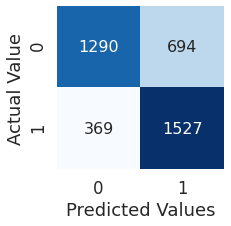

In [50]:
yhat_dev_cnn0 = agn_NN.predict(x_dev_nn, batch_size=512, verbose=1)
yhat_dev_cnn = np.where(yhat_dev_cnn0 >= 0.5, 1, 0)
#yhat_dev = np.argmax(yhat_dev0, axis=1)
yhat_train_cnn0 = agn_NN.predict(x_train_nn, batch_size=512, verbose=1)
yhat_train_cnn = np.where(yhat_train_cnn0 >= 0.5, 1, 0)
#yhat_train = np.argmax(yhat_train0, axis=1)
print(f"The training set f1 score is {f1_score(y_train, yhat_train_cnn, average='weighted')}")
print(f"the dev set f1 score is {f1_score(y_dev, yhat_dev_cnn, average='weighted')}") 

# Plot Confusion Matrix
conf_matrix(y_dev, yhat_dev_cnn)

<font color='green'>Model Summary

In [51]:
agn_NN.summary()

Model: "AGN_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 1, 1)]        0         
_________________________________________________________________
conv0 (Conv2D)               (None, 26, 1, 16)         32        
_________________________________________________________________
bn0 (BatchNormalization)     (None, 26, 1, 16)         64        
_________________________________________________________________
activation (Activation)      (None, 26, 1, 16)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 1, 32)         544       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 1, 32)         128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 1, 32)         0    

In [ ]:
# open a terminal and run
tensorboard --logdir=/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_1/logs --port=6008

In [23]:
%load_ext tensorboard

In [25]:
%tensorboard --logdir /data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_1/logs

In [65]:
print(agn_NN.history.history.keys())

dict_keys([])


In [52]:
print(agn_NN.history)

<font color='green'> Plot

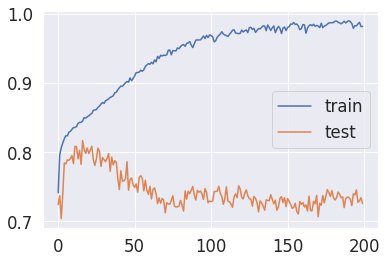

In [53]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

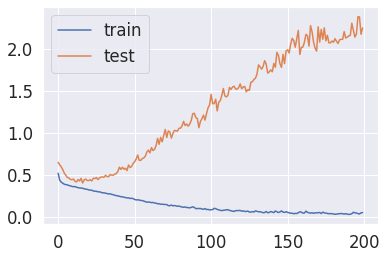

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<font color='green'> Early stopping
see https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

<font color='green'>Save model to file

In [55]:
agn_NN.save('agn_NN.pd')

INFO:tensorflow:Assets written to: agn_NN.pd/assets


In [56]:
%store yhat_train_cnn
%store yhat_dev_cnn

Stored 'yhat_train_cnn' (ndarray)
Stored 'yhat_dev_cnn' (ndarray)


In [57]:
yhat_dev_prob_cnn = yhat_dev_cnn0
yhat_train_prob_cnn = yhat_train_cnn0
%store yhat_dev_prob_cnn
%store yhat_train_prob_cnn

Stored 'yhat_dev_prob_cnn' (ndarray)
Stored 'yhat_train_prob_cnn' (ndarray)
